Reference: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of normal ECGs in the training data. 

Then, it measures the reconstruction loss for both the normal and abnormal ECGs in the test data.

The reconstruction loss for the instances of the abnormal ECGs in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).

Then, if the reconstruction loss of a normal ECG in the training data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal ECG(s) and F for abnormal ECG(s)), the confusion matrix and the accuracy is calculated.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model

Loading the ECG5000 data and forming arrays of the normal training data and the test data (normal and abnormal)

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Parse the data so it can be split creating a variable containing the labels and another containing the data. 

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data so the features are treated equally:

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

The autoencoder is trained using only the normal rhythms, which are labeled in this dataset as 1. Here the normal rhythms is separated from the abnormal rhythms.

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plotting a normal ECG from the training set 

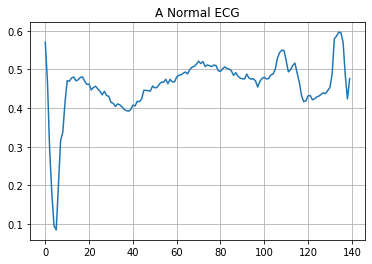

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plotting an anomalous ECG.

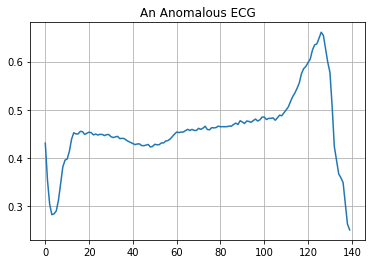

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

Building the Anomaly Detection Model:

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Compiling the model using Adam optimizer and Mean Squared Error as the loss function:

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

Note we train the Autoencoder only on the normal ECG training set but both the normal and abnormal data is contained in the test set:

In [10]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
5/5 [==============================] - 3s 51ms/step - loss: 0.0582 - val_loss: 0.0533
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0560 - val_loss: 0.0517
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0534 - val_loss: 0.0499
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0500 - val_loss: 0.0485
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0463 - val_loss: 0.0471
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0426 - val_loss: 0.0446
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0390 - val_loss: 0.0426
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0358 - val_loss: 0.0416
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0330 - val_loss: 0.0404
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0308 - val_loss: 0.0396
Epoch 11/100
5/5 [=

Plotting the training and validation loss for each epoch of training:

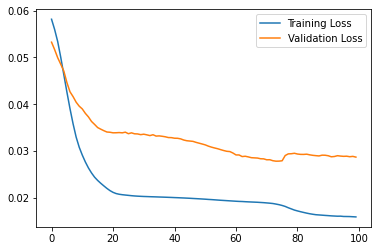

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plotting a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

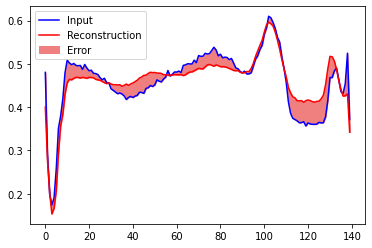

In [13]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Now, we will do the same for the anomalous data:

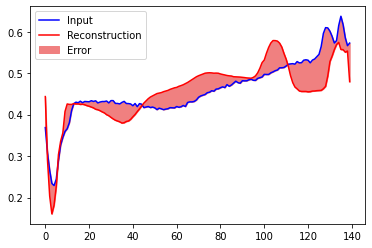

In [14]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

We now detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold $\mu + 2.5*\sigma$, where $\mu, \sigma$ is the calculated for normal examples from the training set. We then will classify future examples as anomalous if the reconstruction error is higher than this threshold $2.5*\sigma$ from the training set.

Plotting the reconstruction error on normal ECGs from the training set

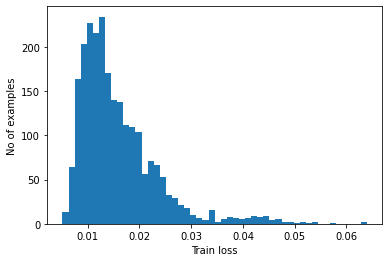

In [15]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Initializing our threshold:

In [16]:
threshold = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03512435918673873


Examining the reconstruction error for the anomalous examples in the test set, it's notable that most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

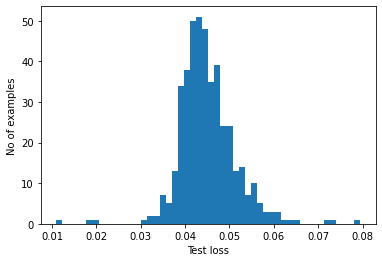

In [17]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [24]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], labels[labels == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], labels[labels == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [25]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Confusion Matrix: 
 prediction: F      T 
             449   551
 label: F   [[429   11]    440
        T    [20   540]]   560
Accuracy = 0.969
Precision = 0.9800362976406534
Recall = 0.9642857142857143


Distribution of the reconstruction losses of the test data (normal and abnormal)

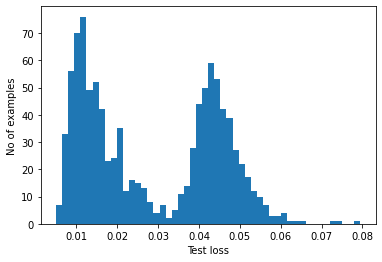

In [26]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()